# Option II - E-Commerce & Retail B2B Case Study

## Import Libaries

In [1]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_theme(style="whitegrid")

## Data Cleaning & Preparation

### Load Data

In [2]:
# import Received Payments Data
received = pd.read_csv('data/Received_Payments_Data.csv', encoding='UTF-8')
received.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [3]:
# import Open Invoice data
open = pd.read_csv('data/Open_Invoice_data.csv', encoding='UTF-8', encoding_errors='replace')
open.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [4]:
open[open['Transaction Number'] == 'RTD-�55,915.30-260721']

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
1084,04-APR-2022 01:07:01,Related Party,MANF Corp,48601.0,"RTD-�55,915.30-260721",26/07/2021,Immediate,26/07/2021,SAR,-151,PAYMENT,253,-40,7/27/2021 23:37


### Refine the Data

In [5]:
# check variable types
received.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [6]:
# Remove unecessary columns based on the Data Dictionary
received.drop(inplace=True, columns=[
    'RECEIPT_DOC_NO',  # reference number
    'Local Amount', # use USD amount instead
    'INVOICE_ALLOCATED', # reference number
    'CUSTOMER_NAME', # use CUSTOMER_NUMBER instead
])

In [7]:
# Remove records with Invoice Value equal to 0
received = received[received['USD Amount'] != 0]

In [8]:
# format date variables
date_cols = ['RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE']

for col in date_cols:
    received[col] = pd.to_datetime(received[col], format='%d-%b-%y')

In [9]:
# calculate TARGET variable
received['LATE_PAYMENT'] = received.apply(
    lambda x: 
        1 if (x['DUE_DATE'] - x['RECEIPT_DATE']).days < 0 # if Receipt Date is after Due Date then return 1
        else 0
    , axis= 1
)

In [10]:
# assign categorical variables
cate_cols = received.select_dtypes(include=['object']).columns.to_list()

# check the values in the categorical variables
for i in cate_cols:
    print(received[i].value_counts(normalize=True))
    print('\n ------------------------------------------- \n')

RECEIPT_METHOD
WIRE             0.897318
AP/AR Netting    0.052224
CHEQUE           0.037409
CASH             0.008426
I/C WIRE         0.002273
PDC              0.002263
I/C Check        0.000065
I/C CASH         0.000022
Name: proportion, dtype: float64

 ------------------------------------------- 

CLASS
PMT    1.0
Name: proportion, dtype: float64

 ------------------------------------------- 

CURRENCY_CODE
AED    0.388176
SAR    0.385558
USD    0.208607
EUR    0.015494
GBP    0.001401
BHD    0.000636
KWD    0.000108
QAR    0.000022
Name: proportion, dtype: float64

 ------------------------------------------- 

PAYMENT_TERM
60 Days from Inv Date                                      0.212712
30 Days from Inv Date                                      0.151081
60 Days from EOM                                           0.134812
30 Days from EOM                                           0.121764
15 Days from EOM                                           0.081165
Immediate Payment     

In [11]:
# remaping some of the categorical values
received['PAYMENT_TERM'] = received['PAYMENT_TERM'].replace({'Immediate' : 'Immediate Payment'})

# binary transform
received['INVOICE_TYPE-GOODS'] = received['INVOICE_TYPE'].map({'Goods' : 1, 'Non Goods' : 0}).astype(int)
received.drop(columns= 'INVOICE_TYPE', inplace=True)

received['INVOICE_CLASS-INV'] = received['INVOICE_CLASS'].map({'INV' : 1, 'CM' : 0, 'DM' : 0}).astype(int)
received.drop(columns= 'INVOICE_CLASS', inplace=True)

# drop feature with 1 value
received.drop(columns= 'CLASS', inplace= True)

In [12]:
# define function to quickly map insignificant values to 'other'
def remove_insignificants(data, threshold = 0.05):
    proportions = data.value_counts(normalize=True)

    # Create a list of categories to keep (above the threshold)
    significant_categories = proportions[proportions > threshold].index.tolist()

    # Create a mapping where significant categories map to themselves and others map to 'Other'
    mapping = {category: (category if category in significant_categories else 'other') for category in data.unique()}

    # Apply the mapping to the DataFrame
    data.replace(mapping, inplace = True)

In [13]:
# reduce the insignificants in the dataset
remove_insignificants(received['RECEIPT_METHOD'], 0.03)
remove_insignificants(received['CURRENCY_CODE'], 0.02)
remove_insignificants(received['PAYMENT_TERM'], 0.01)
remove_insignificants(received['INVOICE_CURRENCY_CODE'], 0.02)

In [14]:
# re-assign categorical variables
cate_cols = received.select_dtypes(include=['object']).columns.to_list()

### Check for outliers

In [15]:
num_cols = ['USD Amount']

<Axes: xlabel='USD Amount'>

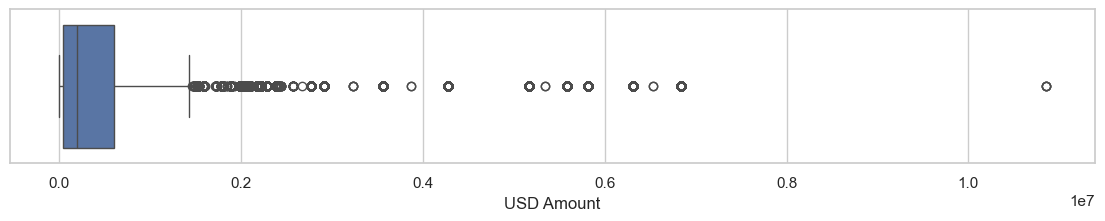

In [16]:
# plot the outliers using boxplot
plt.figure(figsize= (14, 2))
sns.boxplot(received['USD Amount'].astype(int), orient= 'h')

In [17]:
# use quartiles to remove outliers
received['USD Amount'].describe(percentiles=[.05, .1, .25, .5, .75, .9, .95, .97, .99]).astype(int)

count       92811
mean       537645
std        954807
min             1
5%           2572
10%          7829
25%         40452
50%        191287
75%        599613
90%       1257455
95%       2101629
97%       2771599
99%       5814128
max      10849828
Name: USD Amount, dtype: int32

> There are outliers in the 'USD Amount' that will have negative impact on the model's performance

In [18]:
# remove the outliers base on the quantile 95%
received = received[received['USD Amount'] < received['USD Amount'].quantile(0.95)]

## Clustering on Customer-level

#### Prepare customer-level data

In [19]:
# calculate how early the payment was
received['DAYS_EARLY'] = (received['DUE_DATE'] - received['RECEIPT_DATE']).dt.days

# check outliers
received['DAYS_EARLY'].describe(percentiles=[.01, .02, .05, .1, .25, .5, .75, .9, .95, .97, .99]).astype(int)

count    87955
mean       -68
std        198
min      -3873
1%       -1047
2%        -863
5%        -467
10%       -127
25%        -47
50%        -12
75%          4
90%         16
95%         29
97%         37
99%         59
max        340
Name: DAYS_EARLY, dtype: int32

In [20]:
# late than 1 year will be considered the same
received['DAYS_EARLY_CAPPED'] = received['DAYS_EARLY'].clip(lower=-365, upper=60)

In [21]:
# calculate the average and standard deviation of each Customer
## the average days early indicates how on time the customer paid their payments
## the standard deviation indicates how consistent the customer was in making payments
customers = received.groupby('CUSTOMER_NUMBER').agg({'DAYS_EARLY_CAPPED': ['mean', 'std']}).fillna(0)
customers.reset_index(inplace=True)
customers.columns = ['CUSTOMER_NUMBER', 'AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED']
customers.head()

,CUSTOMER_NUMBER,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED
0,1044,-57.269147,99.010107
1,1076,-10.664000,27.722689
2,1146,-110.100000,146.279243
3,1154,-41.476190,86.937518
4,1192,-63.407407,20.428598


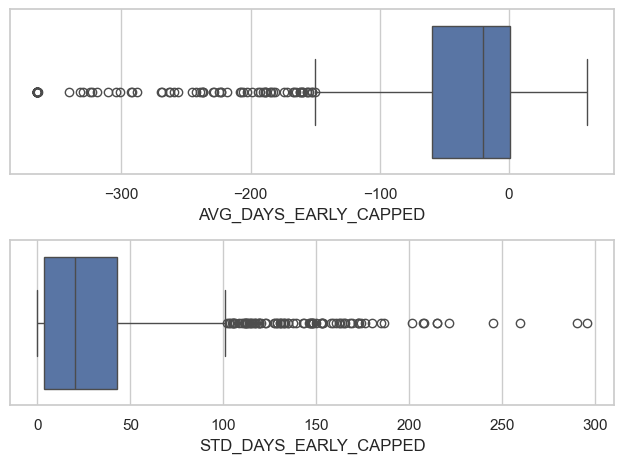

In [22]:
# plot the outliers using boxplot
plt.subplot(2, 1, 1)
sns.boxplot(customers['AVG_DAYS_EARLY_CAPPED'], orient= 'h')
plt.subplot(2, 1, 2)
sns.boxplot(customers['STD_DAYS_EARLY_CAPPED'], orient= 'h')
plt.tight_layout()
plt.show()

In [23]:
# pick out the outliers customers
customers_inliers = customers[
    (customers['AVG_DAYS_EARLY_CAPPED'] > -150) 
    & (customers['STD_DAYS_EARLY_CAPPED'] < 100)
    ]
df_clustering = customers_inliers[['AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED']]

#### Scaling

In [24]:
# instantiate the scaler
scaler = StandardScaler()

# fit transform the data
df_scaled =  scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled, columns=['AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED'])
df_scaled.head()

,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED
0,-0.940927,3.225049
1,0.244832,0.176166
2,-0.539112,2.708718
3,-1.097101,-0.135794
4,-0.678156,3.226162


#### Hierarchical Clustering

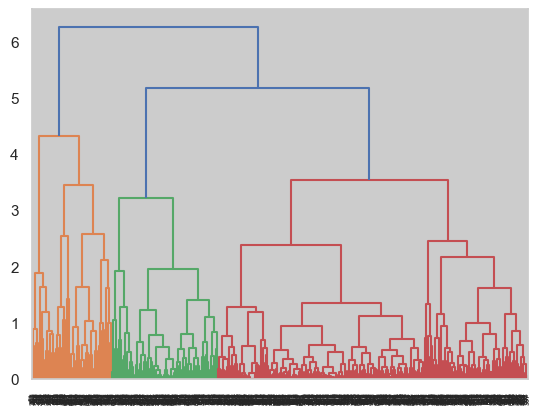

In [25]:
# hierarchical Clustering using Complete Linkage
mergings = linkage(df_scaled[['AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED']], method="complete", metric="euclidean")
dendrogram(mergings)
plt.show()

In [26]:
# cut at 4 clusters
clusters_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )

# asign clusters labels
customers_inliers.loc[:, 'SEGMENT_ID'] = clusters_labels.copy()
customers_inliers.head()

C:\Users\Liem\AppData\Local\Temp\ipykernel_23200\1566788971.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_inliers.loc[:, 'SEGMENT_ID'] = clusters_labels.copy()


,CUSTOMER_NUMBER,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED,SEGMENT_ID
0,1044,-57.269147,99.010107,0
1,1076,-10.664000,27.722689,1
3,1154,-41.476190,86.937518,2
4,1192,-63.407407,20.428598,3
5,1198,-46.941176,99.036129,2


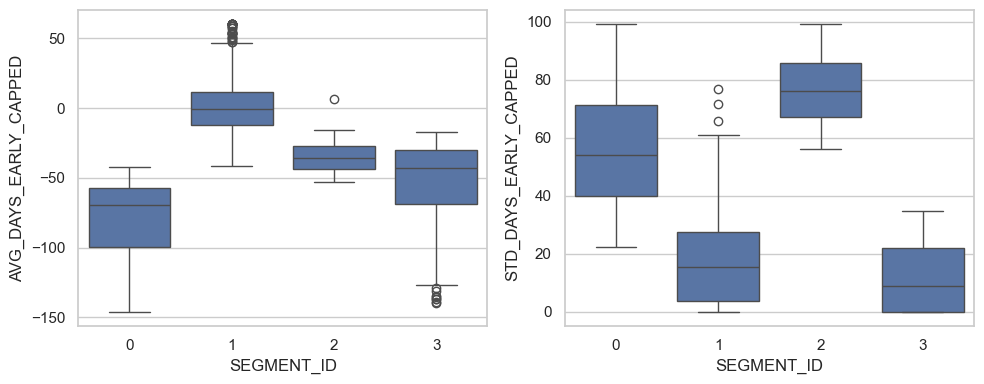

In [27]:
# plot the mean of each Hierarchical cluster
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x='SEGMENT_ID', y='AVG_DAYS_EARLY_CAPPED', data=customers_inliers, ax=axs[0])
sns.boxplot(x='SEGMENT_ID', y='STD_DAYS_EARLY_CAPPED', data=customers_inliers, ax=axs[1])
plt.tight_layout()

> We have ourselve 4 customers segments with different characteristics:
- `SEGMENT_ID` 0 : Customers who make very late payments, with inconsistent late payment durations.
- `SEGMENT_ID` 1 : Customers who consistently make on-time payments.
- `SEGMENT_ID` 2 : Customers who are kinda late, and have inconsistent late payment durations.
- `SEGMENT_ID` 3 : Customers who consistently make late payments.

In [28]:
# merge the clusters labels back into customers data
customers = customers.merge(customers_inliers[['CUSTOMER_NUMBER', 'SEGMENT_ID']], how='left', on='CUSTOMER_NUMBER')

# fill the outliers with segment_id = 0, since they have the same characteristics (late for for than 150 days, with high STD)
customers['SEGMENT_ID'] = customers['SEGMENT_ID'].fillna(0)

# correct the variable type
customers['SEGMENT_ID'] = customers['SEGMENT_ID'].astype(int)
customers.head()

,CUSTOMER_NUMBER,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED,SEGMENT_ID
0,1044,-57.269147,99.010107,0
1,1076,-10.664000,27.722689,1
2,1146,-110.100000,146.279243,0
3,1154,-41.476190,86.937518,2
4,1192,-63.407407,20.428598,3


In [29]:
# use the segmentation data to add segment_id to the received data
received = received.merge(customers[['CUSTOMER_NUMBER', 'SEGMENT_ID']], how='left', on='CUSTOMER_NUMBER')

## EDA

In [30]:
received.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87955 entries, 0 to 87954
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         87955 non-null  object        
 1   CUSTOMER_NUMBER        87955 non-null  int64         
 2   RECEIPT_DATE           87955 non-null  datetime64[ns]
 3   CURRENCY_CODE          87955 non-null  object        
 4   USD Amount             87955 non-null  float64       
 5   INVOICE_CREATION_DATE  87955 non-null  datetime64[ns]
 6   DUE_DATE               87955 non-null  datetime64[ns]
 7   PAYMENT_TERM           87955 non-null  object        
 8   INVOICE_CURRENCY_CODE  87955 non-null  object        
 9   LATE_PAYMENT           87955 non-null  int64         
 10  INVOICE_TYPE-GOODS     87955 non-null  int32         
 11  INVOICE_CLASS-INV      87955 non-null  int32         
 12  DAYS_EARLY             87955 non-null  int64         
 13  D

### Target Variable

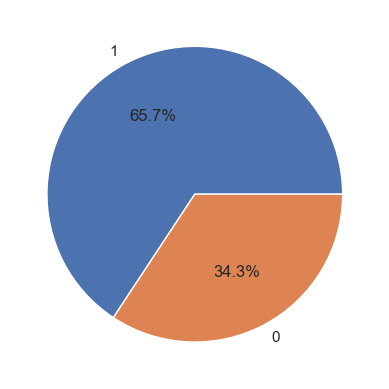

In [31]:
# plot taget variable
sns.set_theme(style="whitegrid")
plt.pie(received['LATE_PAYMENT'].value_counts(), labels= received['LATE_PAYMENT'].value_counts().index, autopct='%1.1f%%')
plt.show()

> About 2/3 payments are Late!

### Categoricals Variables

In [32]:
# add segment_id to our list of categorical variables
cate_cols.append('SEGMENT_ID')
received['SEGMENT_ID'] = received['SEGMENT_ID'].astype('category')

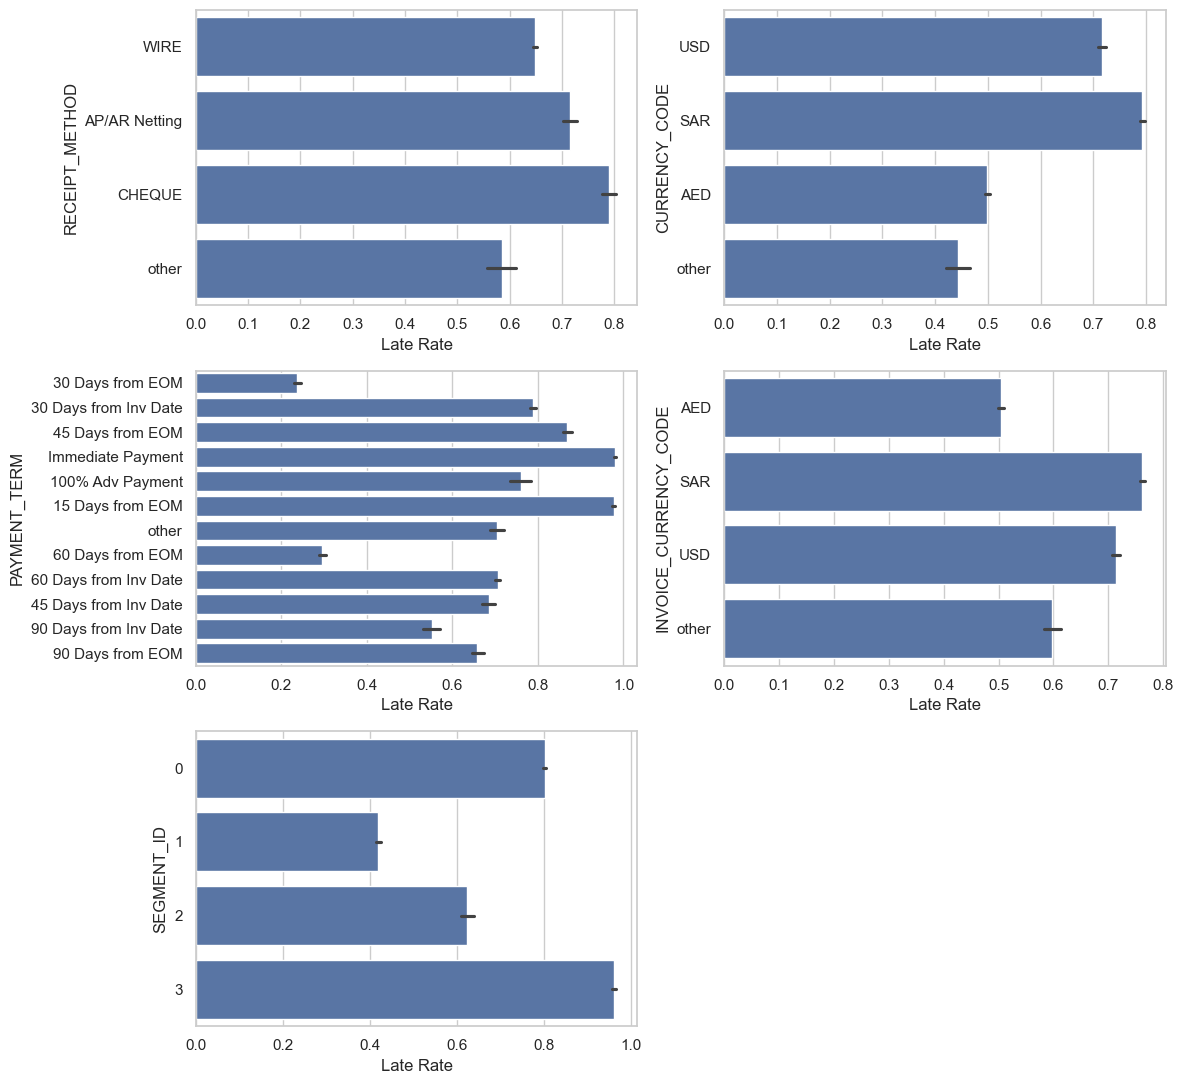

In [33]:
# Lets check the average Late rate of categorical variables
plt.figure(figsize=(12,11))
for i in range(len(cate_cols)):
    plt.subplot(3, 2, i+1)
    sns.barplot(data= received, y= cate_cols[i], x= 'LATE_PAYMENT')
    plt.xlabel('Late Rate')
    plt.ylabel(cate_cols[i])
plt.tight_layout()
plt.show();

> Insights on the Categoricals Variables Analysis:
- Payments with ***"Cheque"*** **payment method** have the highest chance of being late.
- Payments with ***"USD"*** and ***"SAR"*** **payment currency** have much higher change of being late, compared to ***"AED"*** and ***"other"*** **payment currency**. This is also applied on **Invoice's currency**.
- Pretty much all the payments with ***"Immediate Payment"*** **payment term** and ***"15 Days from EOM"*** was late. In contrast, payments with **payment term** ***"30 (or 60) Days from EOM"*** are ussualy paid on time.
- Customers in **SEGMENT_ID** "3" have very high chance of paying late, while customers in **SEGMENT_ID** "1" are less likely to.

### Numerical Variables

<Axes: xlabel='LATE_PAYMENT', ylabel='USD Amount'>

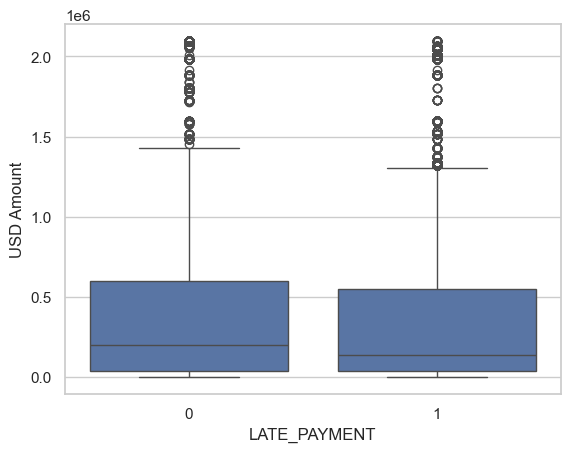

In [34]:
# plot payment value
sns.boxplot(x='LATE_PAYMENT', y='USD Amount', data=received)

> The payment was made on time or late, have nothing to do with the payment value in USD.

In [35]:
received['INVOICE_CREATION_DATE'].dt.year.value_counts()

INVOICE_CREATION_DATE
2021    54714
2020    28431
2019     2657
2018     1800
2017      207
2016      142
2015        4
Name: count, dtype: int64

<Axes: xlabel='DUE_MONTH', ylabel='LATE_PAYMENT'>

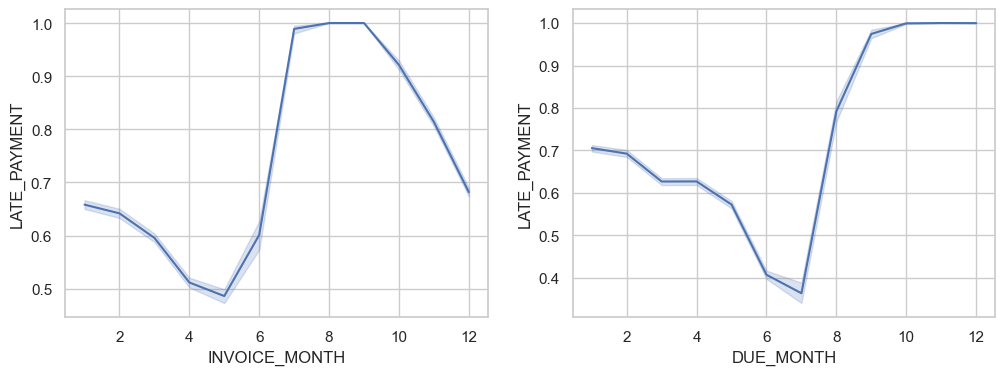

In [36]:
# analyze Transaction Date to see if there are any patterns
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
received['INVOICE_MONTH'] = received['INVOICE_CREATION_DATE'].dt.month
sns.lineplot(x='INVOICE_MONTH', y='LATE_PAYMENT', data=received)

# analyze Transaction Date to see if there are any patterns
received['DUE_MONTH'] = received['DUE_DATE'].dt.month
plt.subplot(1,2,2)
sns.lineplot(x='DUE_MONTH', y='LATE_PAYMENT', data=received)

> Insights on Invoice Creation Date and Due Date:
- Seems like during August (for Invoice Month) and at the end of the year (for Due Month), the chane of a late payment is significantly higher. 
- Middle of the year is more likely to receive payment on time.

<Axes: xlabel='INVOICE_CLASS-INV', ylabel='LATE_PAYMENT'>

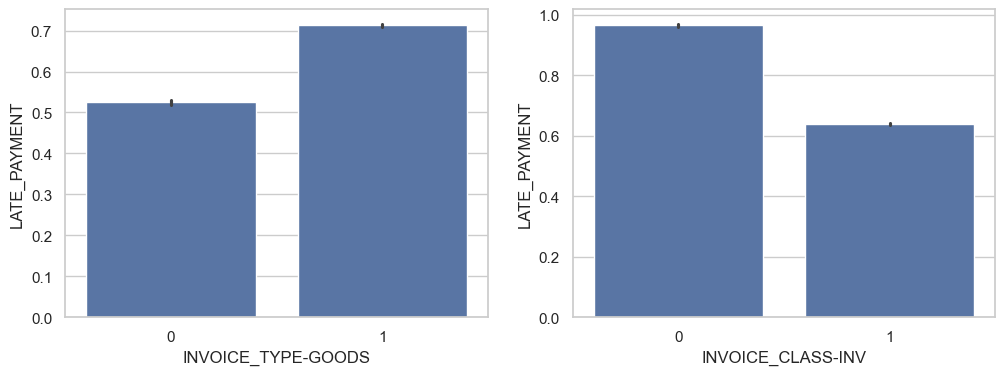

In [37]:
# analyze bi variables
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='INVOICE_TYPE-GOODS', y='LATE_PAYMENT', data=received)

plt.subplot(1, 2, 2)
sns.barplot(x='INVOICE_CLASS-INV', y='LATE_PAYMENT', data=received)

> Insights on the binary variables:
- With **Invoice type** created for ***"physical goods"***, the change of getting a late payment is higher than Invoice created for ***"services"***
- **Invoice classes** ***"Invoice"*** have lower change of a late payment, compared to ***"other"*** classes

## Dummy Creation

In [38]:
# clean up unecessary columns
received.drop(
    inplace=True, 
    columns=['CUSTOMER_NUMBER', 'USD Amount', 'RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE', 'DAYS_EARLY', 'DAYS_EARLY_CAPPED']
)

In [39]:
# preview variables before dummy creation
received.head()

,RECEIPT_METHOD,CURRENCY_CODE,PAYMENT_TERM,INVOICE_CURRENCY_CODE,LATE_PAYMENT,INVOICE_TYPE-GOODS,INVOICE_CLASS-INV,SEGMENT_ID,INVOICE_MONTH,DUE_MONTH
0,WIRE,USD,30 Days from EOM,AED,1,0,1,0,11,12
1,WIRE,SAR,30 Days from Inv Date,SAR,1,0,1,1,12,1
2,WIRE,SAR,30 Days from Inv Date,SAR,0,0,1,1,1,3
3,WIRE,SAR,30 Days from Inv Date,SAR,1,0,1,0,12,1
4,WIRE,SAR,30 Days from Inv Date,SAR,1,0,1,1,12,1


In [40]:
# list of variables to be dummified
dummy_cols = [
    'RECEIPT_METHOD',
    'CURRENCY_CODE',
    'PAYMENT_TERM',
    'INVOICE_CURRENCY_CODE',
    'SEGMENT_ID'
]

In [ ]:
# Get the dummy variables for categorical variables.
dummies = pd.get_dummies(received[dummy_cols], columns= dummy_cols, drop_first= True, dtype= int)

# merge the dummy variables with the original dataframe
data = pd.concat([received, dummies], axis= 1)
data.drop(dummy_cols, axis= 1, inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87955 entries, 0 to 87954
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   LATE_PAYMENT                        87955 non-null  int64
 1   INVOICE_TYPE-GOODS                  87955 non-null  int32
 2   INVOICE_CLASS-INV                   87955 non-null  int32
 3   INVOICE_MONTH                       87955 non-null  int32
 4   DUE_MONTH                           87955 non-null  int32
 5   RECEIPT_METHOD_CHEQUE               87955 non-null  int32
 6   RECEIPT_METHOD_WIRE                 87955 non-null  int32
 7   RECEIPT_METHOD_other                87955 non-null  int32
 8   CURRENCY_CODE_SAR                   87955 non-null  int32
 9   CURRENCY_CODE_USD                   87955 non-null  int32
 10  CURRENCY_CODE_other                 87955 non-null  int32
 11  PAYMENT_TERM_15 Days from EOM       87955 non-null  int32
 12  PAYM

## Test-Train split & scaling

## Model Building

## Model Evaluation

## Predictions on the Test set